In [30]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astroduet.image_utils import find, ap_phot, run_daophot, estimate_background, construct_image
from astroduet.diff_image import py_zogy
from astroduet.config import Telescope
from astroduet.utils import duet_abmag_to_fluence
from astropy.io import fits
from astropy.table import Table
from photutils import find_peaks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
duet = Telescope(config='minimum_mass')

exposure = 300 * u.s
frame = np.array([30,30]) # Dimensions of the image I'm simulating in DUET pixels (30x30 ~ 3x3 arcmin)

oversample = 5
pixel_size_init = duet.pixel / oversample

psf_model = duet.psf_model(pixel_size=pixel_size_init, x_size=25, y_size=25)

psf_os = psf_model.array

#psf_os = gaussian_psf(psf_fwhm,(25,25),pixel_size_init)
shape = (5, 5, 5, 5)
psf_array = psf_os.reshape(shape).sum(-1).sum(1)

psf_fwhm_pix = duet.psf_fwhm / duet.pixel

path = '../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/'
sfb = '21.0'
src_mag = ['20.80','20.90','21.00','21.10','21.20']

In [ ]:
# Set up results table
# columns: galaxy mag, source input mag, source input count rate, distance from galaxy center, reference depth, source detected True/False, 
# if True: retrieved count rate, count rate error; number of false positives
tab_test = Table(np.zeros(9), names=('galmag', 'srcmag', 'src-ctrate', 'dist', 'ref_depth', 'detected',
                                                'ctrate', 'ctrate_err', 'false-pos'), dtype=('f8','f8','f8','f8',
                                                'i8','b','f8','f8','i8'), meta={'name': 'Spiral - low zodi - DUET1'})

#for sfb in sfb:
hdu_ref = fits.open(path+'best_duet1_spiral_21.0_zodi-low_reference.fits')

for i in range(hdu_ref[0].header['NEXTEND']):
    # Prepare reference image:
    ref_image_rate = hdu_ref[i+1].data / hdu_ref[i+1].header['EXPTIME'] *u.ph / u.s
    ref_bkg, ref_bkg_rms_median = estimate_background(ref_image_rate, method='1D', sigma=2)
    ref_rate_bkgsub = ref_image_rate - ref_bkg
    s_r = np.sqrt(ref_image_rate)
    sr = np.mean(s_r)
    # Get depth of reference image
    ref_depth = hdu_ref[i+1].header['NFRAMES']
    
    for srcmag in src_mag:
        hdu_im = fits.open(path+'best_duet1_spiral_21.0_zodi-low_src-'+srcmag+'.fits')
        # Get input countrate
        src_ctrate = duet.fluence_to_rate(duet_abmag_to_fluence(float(srcmag)*u.ABmag, duet.bandpass1))
        for j in range(hdu_im[0].header['NEXTEND']):
            # Get source distance from center of galaxy
            dist = np.sqrt((14.5-hdu_im[j+1].header['SRC_POSX'])**2 + (14.5-hdu_im[j+1].header['SRC_POSY'])**2) * duet.pixel
            # Prepare science image:
            image_rate = hdu_im[j+1].data / hdu_im[j+1].header['EXPTIME'] *u.ph / u.s
            image_bkg, image_bkg_rms_median = estimate_background(image_rate, method='1D', sigma=2)
            image_rate_bkgsub = image_rate - image_bkg
            s_n = np.sqrt(image_rate)
            sn = np.mean(s_n)
            
            dx, dy = 0.1, 0.01 # Astrometric uncertainty (sigma)
            # Run zogy:
            diff_image, d_psf, s_corr = py_zogy(image_rate_bkgsub.value,
                                ref_rate_bkgsub.value,
                                psf_array,psf_array,
                                s_n.value,s_r.value,
                                sn.value,sr.value,dx,dy)

            diff_image *= image_rate_bkgsub.unit
            # Find sources:
            star_tbl, bkg_image, threshold = find(diff_image,psf_fwhm_pix.value,method='peaks')
            
            # Define separation from input source and find nearest peak:
            if len(star_tbl) > 0:
                sep = np.sqrt((star_tbl['x'] - hdu_im[j+1].header['SRC_POSX'])**2 + (star_tbl['y'] - hdu_im[j+1].header['SRC_POSY'])**2)
                src = np.argmin(sep)
                if sep[src] < 1.5:
                    detected = True
                    # Run aperture photometry
                    result, apertures, annulus_apertures = ap_phot(diff_image,star_tbl[src],duet.read_noise,hdu_im[j+1].header['EXPTIME']*u.s)
                    ctrate, ctrate_err = result['aper_sum_bkgsub'],result['aperture_sum_err']
                    fp = len(star_tbl) - 1
                else:
                    detected = False
                    ctrate, ctrate_err = np.nan, np.nan
                    fp = len(star_tbl)
            else:
                detected = False
                ctrate, ctrate_err = np.nan, np.nan
                fp = len(star_tbl)
                
            tab_test.add_row([float(sfb), float(srcmag), src_ctrate, dist, ref_depth, detected,
                                               ctrate, ctrate_err, fp])
            
        hdu_im.close()
hdu_ref.close()
tab_test.remove_row(0)

In [ ]:
tab_test[tab_test['ref_depth']==3]

threshold =  0.2522657317791433 ph / s
xcenter ycenter aperture_sum aper_sum_bkgsub aperture_sum_err percent_error
  pix     pix      ph / s         ph / s          ph / s                   
------- ------- ------------ --------------- ---------------- -------------
     15      11    0.6594638      0.63982885      0.083382841     13.032054
     15      14  -0.89841687      -1.4481956       0.10144596    -7.0049904
     17      14    1.1020239       2.1426765       0.10197204     4.7590966
     19      15   -0.1981153      0.29275855      0.075466891     25.777861
     10      16  -0.36456815     -0.28602834      0.083168623    -29.077057
     12      16    2.5768645       2.9420746       0.12992758     4.4161892
     15      17  -0.63116264     -0.67828653      0.077033963    -11.357142


1.3363843375607136


PSF-fitting complete
 id      flux_fit             flux_unc            percent_error    
          ph / s               ph / s                 ph / s       
--- -----------------

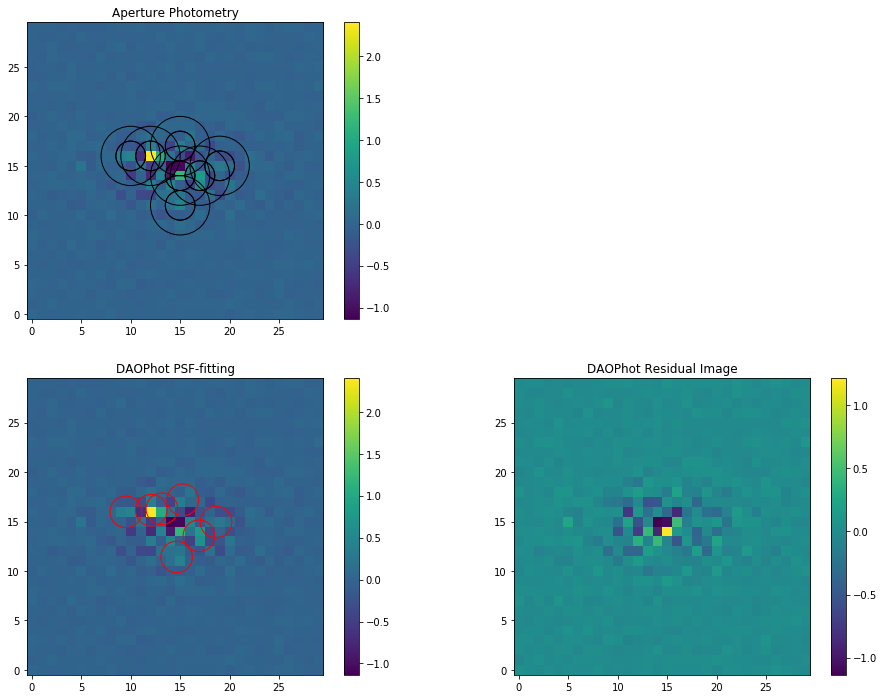

In [4]:
hdu_ref = fits.open(path+'best_duet1_spiral_21.0_zodi-low_reference.fits')
hdu_im = fits.open(path+'best_duet1_spiral_21.0_zodi-low_src-20.90.fits')

ref_ext = 2
im_ext = 1

image_rate = hdu_im[im_ext].data / hdu_im[im_ext].header['EXPTIME'] *u.ph / u.s
ref_image_rate = hdu_ref[ref_ext].data / hdu_ref[ref_ext].header['EXPTIME'] *u.ph / u.s

hdu_ref.close()
hdu_im.close()

# Use ZOGY algorithm to create difference image
image_bkg, image_bkg_rms_median = estimate_background(image_rate, method='1D', sigma=2)
ref_bkg, ref_bkg_rms_median = estimate_background(ref_image_rate, method='1D', sigma=2)
image_rate_bkgsub, ref_rate_bkgsub = image_rate - image_bkg, ref_image_rate - ref_bkg

s_n, s_r = np.sqrt(image_rate), np.sqrt(ref_image_rate) # 2D uncertainty (sigma) - that is, noise on the background
sn, sr = np.mean(s_n), np.mean(s_r) # Average uncertainty (sigma)
dx, dy = 0.1, 0.01 # Astrometric uncertainty (sigma)
diff_image, d_psf, s_corr = py_zogy(image_rate_bkgsub.value,
                                    ref_rate_bkgsub.value,
                                    psf_array,psf_array,
                                    s_n.value,s_r.value,
                                    sn.value,sr.value,dx,dy)

diff_image *= image_rate_bkgsub.unit

# Run find
star_tbl, bkg_image, threshold = find(diff_image,psf_fwhm_pix.value,method='peaks')
print('threshold = ', threshold)

if len(star_tbl) > 0:
    sep = np.sqrt((star_tbl['x'] - hdu_im[im_ext].header['SRC_POSX'])**2 + (star_tbl['y'] - hdu_im[im_ext].header['SRC_POSY'])**2)
    # Run aperture photometry
    src = np.argmin(sep)
    if sep[src] < 1.5:
        result, apertures, annulus_apertures = ap_phot(diff_image,star_tbl,duet.read_noise,hdu_im[im_ext].header['EXPTIME']*u.s)
        result['percent_error'] = result['aperture_sum_err'] / result['aper_sum_bkgsub'] * 100
        print(result['xcenter','ycenter','aperture_sum','aper_sum_bkgsub','aperture_sum_err','percent_error'])
        print('\n')
        print(sep[src])
        print('\n')

# Run PSF-fitting photometry
result, residual_image = run_daophot(diff_image,threshold,star_tbl,niters=1)
result['percent_error'] = result['flux_unc'] / result['flux_fit'] * 100
print(result['id','flux_fit','flux_unc','percent_error'])

# Plots
plt.figure(figsize=[16,12])
plt.subplot(221)
plt.title('Aperture Photometry')
plt.imshow(diff_image.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
apertures.plot()
annulus_apertures.plot()

plt.subplot(223)
plt.title('DAOPhot PSF-fitting')
plt.imshow(diff_image.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.scatter(result['x_fit'],result['y_fit'],marker='o',s=1000,facecolors='none',edgecolors='r',lw=1)

plt.subplot(224)
plt.title('DAOPhot Residual Image')
plt.imshow(residual_image.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()

In [ ]:
star_tbl['x_0'] = star_tbl['x']
star_tbl

In [ ]:
tab_test2 = Table(np.zeros(9), names=('galmag', 'srcmag', 'src-ctrate', 'dist', 'ref_depth', 'detected',
                        'ctrate', 'ctrate_err', 'false-pos'), dtype=('f8','f8','f8','f8','i8','b','f8','f8','i8'), meta={'name': 'Spiral - low zodi - DUET1'})



In [22]:
srcmag = np.linspace(17.0, 23.9, num=70)

In [27]:
sfb_arr = np.arange(20.,30.).astype(str)

In [48]:
duet.read_noise = 0
duet.jitter_rms = 1 *u.arcsec

In [49]:
im = construct_image(frame, exposure, duet=duet, source=1 * u.ph/u.s, sky_rate=0 *u.ph/u.s)

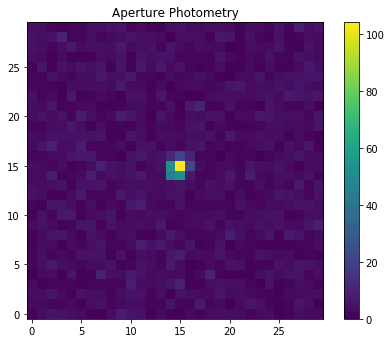

In [50]:
plt.figure(figsize=[16,12])
plt.subplot(221)
plt.title('Aperture Photometry')
plt.imshow(im.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()